## 1. Imports

In [111]:
import pandas as pd
import numpy as np

from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import (
    MinMaxScaler,
    StandardScaler,
    OneHotEncoder
)

from sklearn.model_selection import (
    cross_val_score,
    train_test_split,
    GridSearchCV
)

from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score,
    roc_curve
)

## 2. Dataset

In [23]:
df = pd.read_csv("./data/star_classification.csv")
df.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


### 2.1. Resumo

Os dados consistem em 100.000 observações do espaço obtidas pelo SDSS (Sloan Digital Sky Survey). Cada observação é descrita por 17 colunas de características e 1 coluna de classe que a identifica como uma estrela, galáxia ou quasar.

obj_ID = Object Identifier, valor único que identifica o objeto no catálogo de imagens utilizado pelo CAS

alfa = Ângulo de ascensão reta (na época J2000)

delta = Ângulo de declinação (na época J2000)

u = Filtro ultravioleta no sistema fotométrico

g = Filtro verde no sistema fotométrico

r = Filtro vermelho no sistema fotométrico

i = Filtro infravermelho próximo no sistema fotométrico

z = Filtro infravermelho no sistema fotométrico

run_ID = Número de execução usado para identificar a verificação específica

rereun_ID = Número de nova execução para especificar como a imagem foi processada

cam_col = Coluna da câmera para identificar a linha de varredura na execução

field_ID = Número do campo para identificar cada campo

spec_obj_ID = ID exclusivo usado para objetos espectroscópicos ópticos (isso significa que 2 observações diferentes com o mesmo spec_obj_ID devem compartilhar a classe de saída)

class = classe do objeto (objeto galáxia, estrela ou quasar)

redshift = valor do redshift com base no aumento do comprimento de onda

plate = ID do plate, identifica cada plate no SDSS

MJD = Data Juliana Modificada, usada para indicar quando um determinado dado do SDSS foi obtido

Fiber_ID = ID da fibra que identifica a fibra que apontou a luz para o plano focal em cada observação

## 3. Limpeza e Tratamento

### 3.2. Remoção de Erros

In [25]:
df = df[df["u"] != -9999]

### 3.3. Resumo dos Dados

In [26]:
df.describe()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
count,9.999900e+04,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.0,99999.000000,99999.000000,9.999900e+04,99999.000000,99999.000000,99999.000000,99999.000000
mean,1.237665e+18,177.628653,24.135552,22.080679,20.631583,19.645777,19.084865,18.768988,4481.403354,301.0,3.511625,186.127011,5.783903e+18,0.576667,5137.027890,55588.653687,449.315613
std,8.438450e+12,96.502612,19.644608,2.251068,2.037384,1.854763,1.757900,1.765982,1964.739021,0.0,1.586913,149.007687,3.324026e+18,0.730709,2952.312485,1808.492217,272.498252
min,1.237646e+18,0.005528,-18.785328,10.996230,10.498200,9.822070,9.469903,9.612333,109.000000,301.0,1.000000,11.000000,2.995191e+17,-0.009971,266.000000,51608.000000,1.000000
25%,1.237659e+18,127.517698,5.147477,20.352410,18.965240,18.135795,17.732280,17.460830,3187.000000,301.0,2.000000,82.000000,2.844137e+18,0.054522,2526.000000,54234.000000,221.000000
50%,1.237663e+18,180.900527,23.646462,22.179140,21.099930,20.125310,19.405150,19.004600,4188.000000,301.0,4.000000,146.000000,5.614896e+18,0.424176,4987.000000,55869.000000,433.000000
75%,1.237668e+18,233.895005,39.901582,23.687480,22.123775,21.044790,20.396510,19.921120,5326.000000,301.0,5.000000,241.000000,8.332365e+18,0.704172,7400.500000,56777.000000,645.000000
max,1.237681e+18,359.999810,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,8162.000000,301.0,6.000000,989.000000,1.412694e+19,7.011245,12547.000000,58932.000000,1000.000000


In [27]:
df.nunique()

obj_ID         78052
alpha          99998
delta          99998
u              93747
g              92650
r              91900
i              92018
z              92006
run_ID           430
rerun_ID           1
cam_col            6
field_ID         856
spec_obj_ID    99999
class              3
redshift       99294
plate           6284
MJD             2180
fiber_ID        1000
dtype: int64

In [28]:
df.isnull().sum()

obj_ID         0
alpha          0
delta          0
u              0
g              0
r              0
i              0
z              0
run_ID         0
rerun_ID       0
cam_col        0
field_ID       0
spec_obj_ID    0
class          0
redshift       0
plate          0
MJD            0
fiber_ID       0
dtype: int64

## 4. Análise Exploratória de Dados

### 4.1. Correlação com Classes

In [29]:
df_aed = df.copy()

In [30]:
ohe = OneHotEncoder()

In [31]:
values_enc = ohe.fit_transform(df_aed["class"].values.reshape(-1, 1)).toarray()

cols_class = ohe.categories_[0]

In [32]:
df_aed[cols_class] = values_enc

In [37]:
df_corr = df_aed.drop("class", axis=1).corr().abs()

In [40]:
df_corr_class = pd.concat(
    [
        df_corr["GALAXY"],
        df_corr["STAR"],
        df_corr["QSO"]
    ], axis=1
).drop(index=["GALAXY", "QSO", "STAR"], axis=0).round(2)

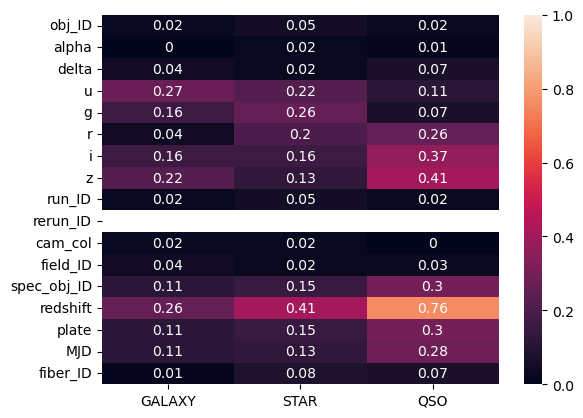

In [41]:
sns.heatmap(df_corr_class, vmax=1, vmin=0, annot=True)

plt.show()

### 4.2. Correlação entre Variáveis

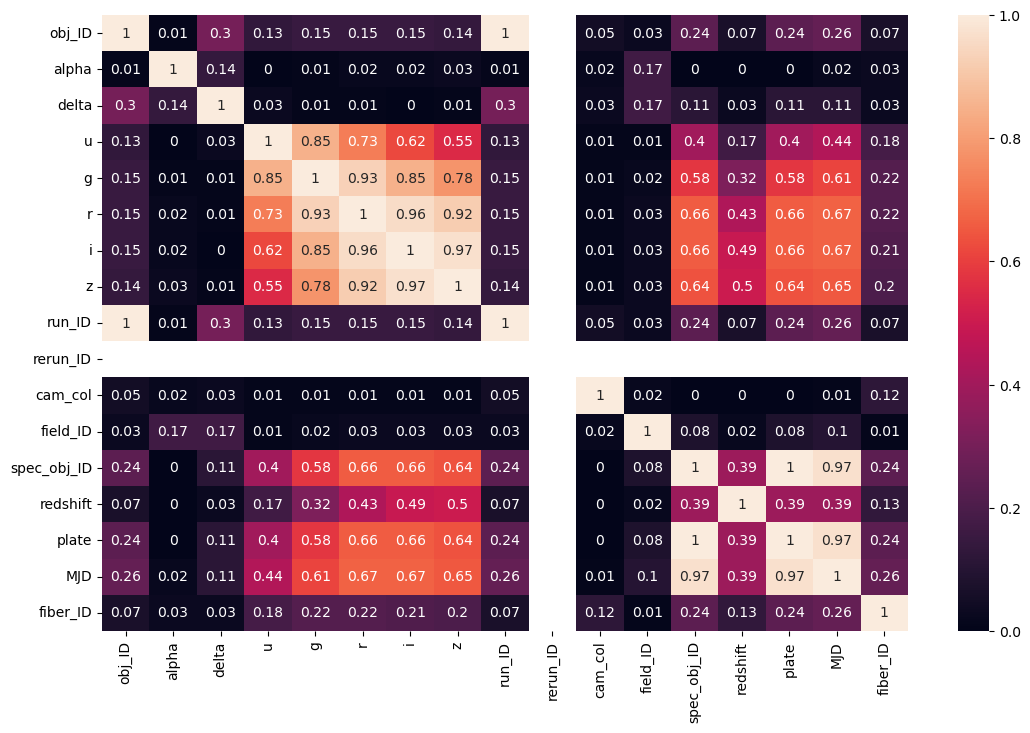

In [43]:
plt.figure(figsize=(13, 8))

sns.heatmap(
    df_aed.drop(["class", "GALAXY", "QSO", "STAR"], axis=1).corr().abs().round(2),
    vmin=0, vmax=1, annot=True
)

plt.show()

### 4.3. Distribuição das Variáveis

#### 4.3.1. Análise Univariada

##### 4.3.1.1. KDE

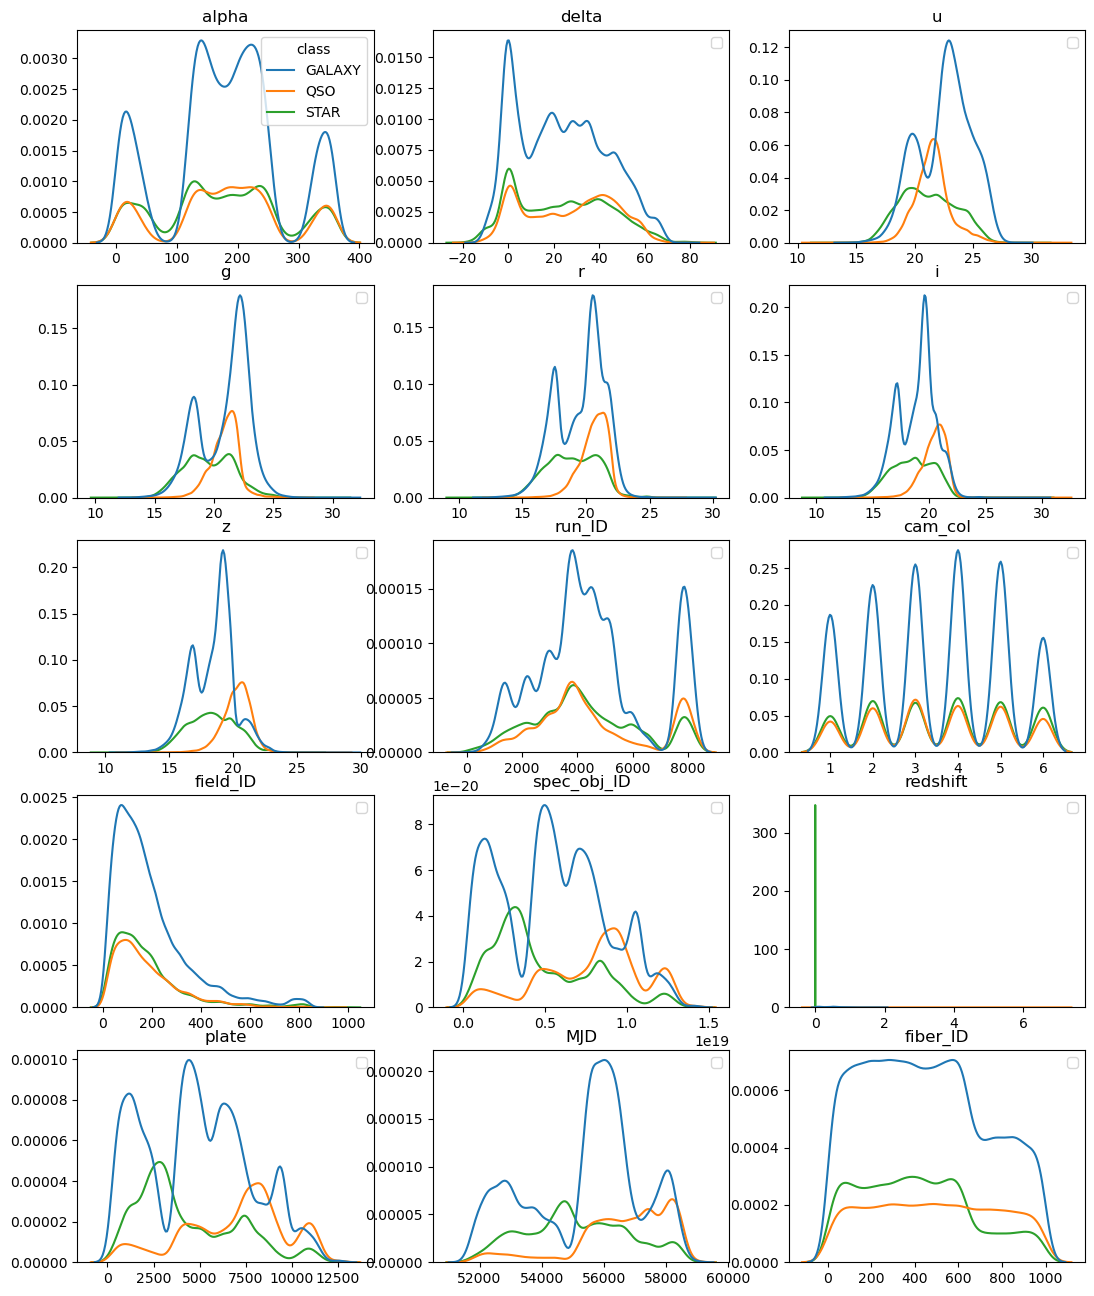

In [55]:
fig, axs = plt.subplots(5, 3, figsize=(13, 16))

cols = df_aed.drop(["rerun_ID", "obj_ID", "class", "GALAXY", "QSO", "STAR"], axis=1).columns

for i, col in enumerate(cols):
    
    k = i // 3
    j = i % 3

    sns.kdeplot(df_aed, x=col, hue="class", ax=axs[k, j])

    if k + j:
        axs[k, j].legend("")

    axs[k, j].set_title(col)
    axs[k, j].set_ylabel("")
    axs[k, j].set_xlabel("")

##### 4.3.1.2. Box

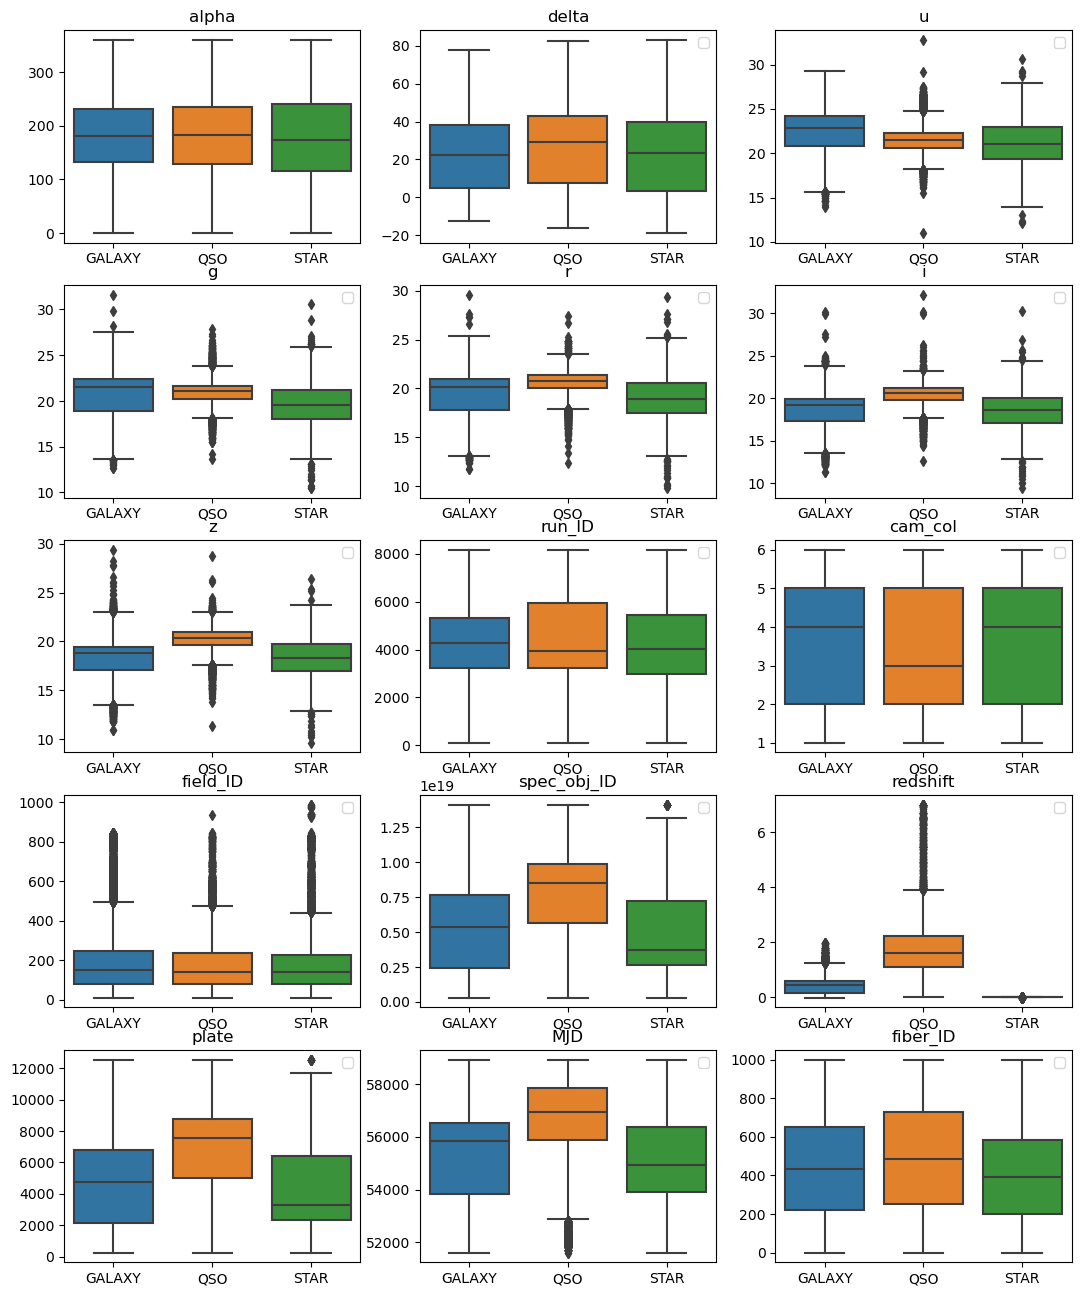

In [57]:
fig, axs = plt.subplots(5, 3, figsize=(13, 16))

cols = df_aed.drop(["rerun_ID", "obj_ID", "class", "GALAXY", "QSO", "STAR"], axis=1).columns

for i, col in enumerate(cols):
    
    k = i // 3
    j = i % 3

    sns.boxplot(df_aed, y=col, x="class", ax=axs[k, j])

    if k + j:
        axs[k, j].legend("")

    axs[k, j].set_title(col)
    axs[k, j].set_ylabel("")
    axs[k, j].set_xlabel("")

#### 4.3.2. Análise Multivariada

In [59]:
df_aed.columns

Index(['obj_ID', 'alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'run_ID',
       'rerun_ID', 'cam_col', 'field_ID', 'spec_obj_ID', 'class', 'redshift',
       'plate', 'MJD', 'fiber_ID', 'GALAXY', 'QSO', 'STAR'],
      dtype='object')

##### 4.3.2.1. Scatter

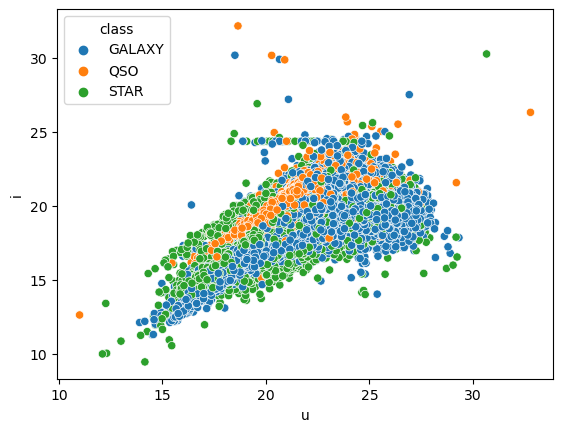

In [87]:
# good combinations
# x, y = "redshift", "z"

x = "u"
y = "i"

sns.scatterplot(df_aed, x=x, y=y, hue="class")

plt.show()

## 5. Modelagem

In [138]:
seed = 94

### 5.1. Geração de diferentes subconjuntos de variáveis

In [24]:
cols_rem = ["obj_ID", "run_ID", "rereun_ID", "cam_col", "field_ID", "spec_obj_ID", "plate", "fiber_ID"]

In [107]:
cols_corr_bet_01 = ["alpha", "delta", "u", "i", "run_ID", "cam_col", "field_ID", "redshift", "fiber_ID", "MJD", "class"]
cols_corr_bet_02 = ["alpha", "delta", "u", "z", "run_ID", "cam_col", "field_ID", "redshift", "fiber_ID", "MJD", "class"]

In [108]:
cols_01 = cols_corr_bet_01
cols_02 = cols_corr_bet_02
cols_03 = list(set(cols_corr_bet_01) - set(cols_rem))
cols_04 = list(set(cols_corr_bet_02) - set(cols_rem))

In [109]:
df_01 = df[cols_01]
df_02 = df[cols_02]
df_03 = df[cols_03]
df_04 = df[cols_04]

### 5.2. Divisão em Treino e Teste

In [136]:
X_training_01, y_training_01 = df_01.drop("class", axis=1), df_01["class"]
X_training_02, y_training_02 = df_02.drop("class", axis=1), df_02["class"]
X_training_03, y_training_03 = df_03.drop("class", axis=1), df_03["class"]
X_training_04, y_training_04 = df_04.drop("class", axis=1), df_04["class"]

In [133]:
st_scaler = StandardScaler()
mm_scaler = MinMaxScaler()

In [134]:
def get_prepared_data(df: pd.DataFrame) -> pd.DataFrame:
    cols = df.columns
    
    df = st_scaler.fit_transform(df)
    df = mm_scaler.fit_transform(df)

    return pd.DataFrame(df, columns=cols)

In [137]:
X_training_01 = get_prepared_data(X_training_01)
X_training_02 = get_prepared_data(X_training_02)
X_training_03 = get_prepared_data(X_training_03)
X_training_04 = get_prepared_data(X_training_04)

In [139]:
X_train_01, X_val_01, y_train_01, y_val_01 = train_test_split(X_training_01, y_training_01, random_state=seed, test_size=0.33, stratify=y_training_01)
X_train_02, X_val_02, y_train_02, y_val_02 = train_test_split(X_training_02, y_training_02, random_state=seed, test_size=0.33, stratify=y_training_02)
X_train_03, X_val_03, y_train_03, y_val_03 = train_test_split(X_training_03, y_training_03, random_state=seed, test_size=0.33, stratify=y_training_03)
X_train_04, X_val_04, y_train_04, y_val_04 = train_test_split(X_training_04, y_training_04, random_state=seed, test_size=0.33, stratify=y_training_04)

### 5.3. Classificação